In [2]:
import os
import time
import copy
import random
import json
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

In [3]:
# Đường dẫn
dataset_dir  = "Dataset/processed"
models_dir   = "models"
metrics_file = "metrics_history.json"
os.makedirs(models_dir, exist_ok=True)

# Hyperparameters
IMG_SIZE    = (224, 224)
BATCH_SIZE  = 8
VAL_RATIO   = 0.15
TEST_RATIO  = 0.15
NUM_EPOCHS  = 10
LR          = 1e-4
WD          = 1e-5
SEED        = 42
DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# random seed
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# list models
model_names = ['resnet50','efficientnet_b0','densenet121','mobilenet_v2']

if os.path.exists(metrics_file):
    with open(metrics_file, "r") as f:
        metrics_history = json.load(f)
else:
    metrics_history = {
        m: {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'train_f1': [], 'val_f1': []}
        for m in model_names
    }

results = {}


In [4]:
def get_model(name: str, num_classes: int = 2, feature_extract: bool = True) -> nn.Module:
    # Select architecture
    if name == 'resnet50':
        m = models.resnet50(pretrained=True)
        m.fc = nn.Linear(m.fc.in_features, num_classes)
    elif name == 'efficientnet_b0':
        m = models.efficientnet_b0(pretrained=True)
        m.classifier[1] = nn.Linear(m.classifier[1].in_features, num_classes)
    elif name == 'densenet121':
        m = models.densenet121(pretrained=True)
        m.classifier = nn.Linear(m.classifier.in_features, num_classes)
    elif name == 'mobilenet_v2':
        m = models.mobilenet_v2(pretrained=True)
        m.classifier[1] = nn.Linear(m.classifier[1].in_features, num_classes)
    else:
        raise ValueError(f"Unknown model: {name}")
    # Freeze backbone if requested
    if feature_extract:
        for p in m.parameters(): p.requires_grad = False
        # Unfreeze classifier layers
        if name == 'resnet50':
            for p in m.fc.parameters(): p.requires_grad = True
        elif name in ('efficientnet_b0','mobilenet_v2'):
            for p in m.classifier[1].parameters(): p.requires_grad = True
        else:
            for p in m.classifier.parameters(): p.requires_grad = True
    return m.to(DEVICE)

In [5]:
# Transforms
transforms_dict = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(0.1,0.1,0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(int(IMG_SIZE[0]*1.14)),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
}

# Load full dataset
full_ds = datasets.ImageFolder(dataset_dir, transform=transforms_dict['train'])
print("Classes:", full_ds.classes)

# Split
total   = len(full_ds)
val_sz  = int(VAL_RATIO * total)
test_sz = int(TEST_RATIO * total)
train_sz= total - val_sz - test_sz
train_ds, val_ds, test_ds = random_split(
    full_ds, [train_sz, val_sz, test_sz],
    generator=torch.Generator().manual_seed(SEED)
)

# Override transforms
train_ds.dataset.transform = transforms_dict['train']
val_ds.dataset.transform   = transforms_dict['val']
test_ds.dataset.transform  = transforms_dict['val']

# DataLoaders
dataloaders = {
    'train': DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4, pin_memory=True),
    'val':   DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True),
    'test':  DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
}
print(f"Dataset sizes → Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

Classes: ['Levitan', 'Non-levitan']
Dataset sizes → Train: 753, Val: 161, Test: 161


In [6]:
for name in model_names:
    ckpt_path = os.path.join(models_dir, f"{name}_best.pth")
    if os.path.exists(ckpt_path) and len(metrics_history[name]['train_loss']) == NUM_EPOCHS:
        print(f"Skipping {name}, checkpoint exists.")
        results[name] = metrics_history[name]['val_f1'][-1]
        continue

    print(f"\n=== Training {name} ===")
    model     = get_model(name)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR, weight_decay=WD)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    best_f1    = 0.0
    best_wts   = copy.deepcopy(model.state_dict())
    epoch_times= []
    start_all  = time.time()

    for epoch in range(1, NUM_EPOCHS+1):
        ep_start = time.time()

        # Train
        model.train()
        running_loss = 0.0
        train_preds, train_labels = [], []
        for x,y in dataloaders['train']:
            x,y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            out = model(x)
            loss= criterion(out,y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * x.size(0)
            p = out.argmax(dim=1)
            train_preds  += p.cpu().tolist()
            train_labels += y.cpu().tolist()
        train_loss = running_loss / len(train_ds)
        train_acc  = accuracy_score(train_labels, train_preds)
        train_f1   = f1_score(train_labels, train_preds, average='weighted')

        # Validation 
        model.eval()
        running_loss = 0.0
        val_preds, val_labels = [], []
        with torch.no_grad():
            for x,y in dataloaders['val']:
                x,y = x.to(DEVICE), y.to(DEVICE)
                out = model(x)
                loss= criterion(out,y)
                running_loss += loss.item() * x.size(0)
                p = out.argmax(dim=1)
                val_preds  += p.cpu().tolist()
                val_labels += y.cpu().tolist()
        val_loss = running_loss / len(val_ds)
        val_acc  = accuracy_score(val_labels, val_preds)
        val_f1   = f1_score(val_labels, val_preds, average='weighted')

        scheduler.step()
        if val_f1 > best_f1:
            best_f1, best_wts = val_f1, copy.deepcopy(model.state_dict())

        # Log metrics
        mh = metrics_history[name]
        mh['train_loss'].append(train_loss)
        mh['val_loss'].append(val_loss)
        mh['train_acc'].append(train_acc)
        mh['val_acc'].append(val_acc)
        mh['train_f1'].append(train_f1)
        mh['val_f1'].append(val_f1)

        # Timing
        ep_time    = time.time() - ep_start
        epoch_times.append(ep_time)
        avg_ep     = sum(epoch_times) / len(epoch_times)
        est_total  = avg_ep * NUM_EPOCHS
        elapsed    = time.time() - start_all

        print(
            f"Epoch {epoch}/{NUM_EPOCHS} | "
            f"Elapsed {elapsed:.1f}s / Est {est_total:.1f}s | "
            f"TrAcc {train_acc:.4f}, TrLoss {train_loss:.4f}, TrF1 {train_f1:.4f} | "
            f"ValAcc {val_acc:.4f}, ValLoss {val_loss:.4f}, ValF1 {val_f1:.4f}"
        )

    # best weights
    torch.save(best_wts, ckpt_path)
    results[name] = best_f1

Skipping resnet50, checkpoint exists.
Skipping efficientnet_b0, checkpoint exists.
Skipping densenet121, checkpoint exists.
Skipping mobilenet_v2, checkpoint exists.


In [7]:
with open(metrics_file, "w") as f:
    json.dump(metrics_history, f, indent=2)
print(f"Metrics history saved to {metrics_file}")

Metrics history saved to metrics_history.json


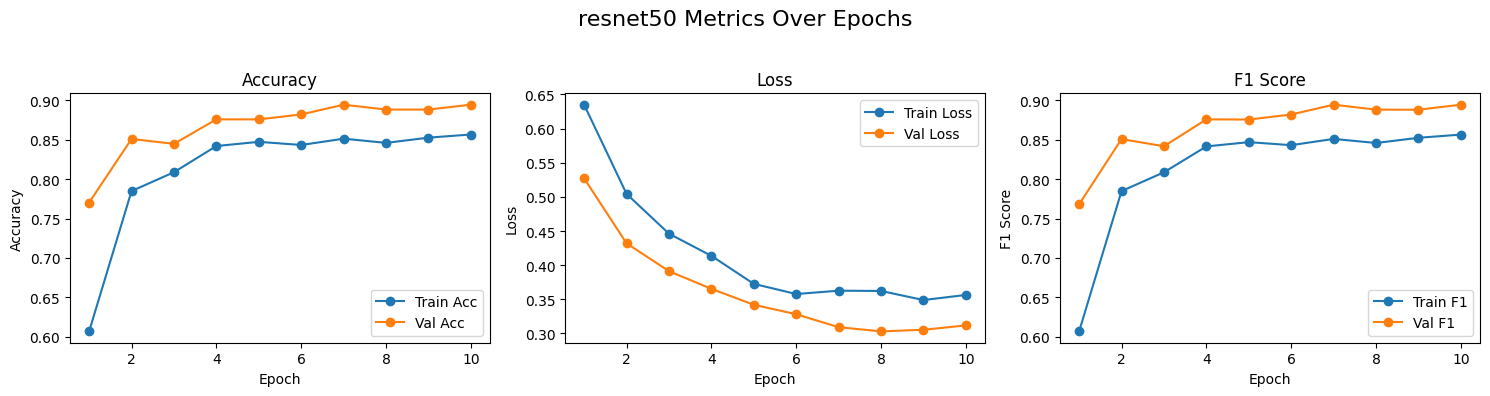

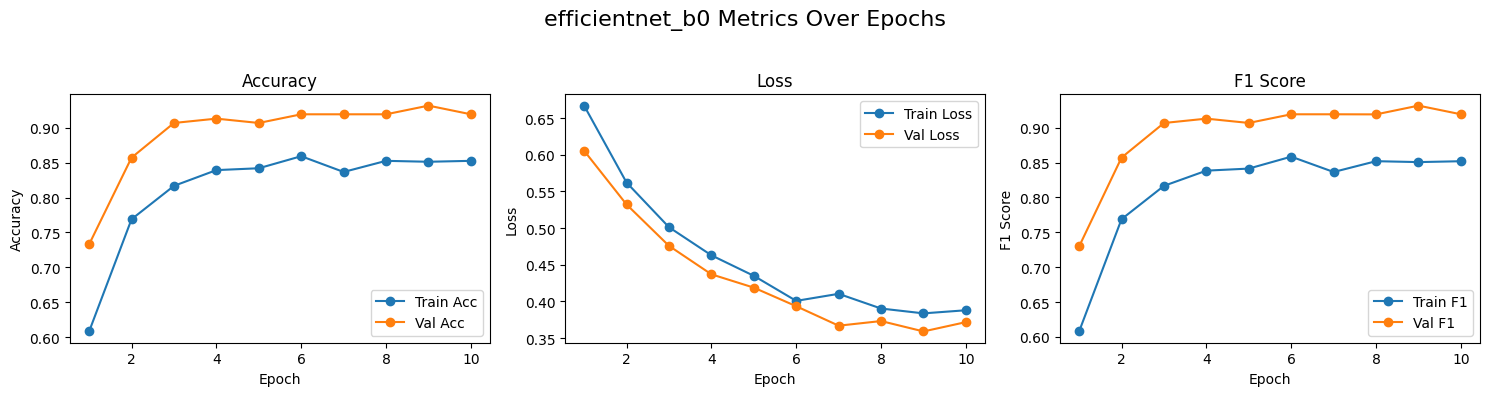

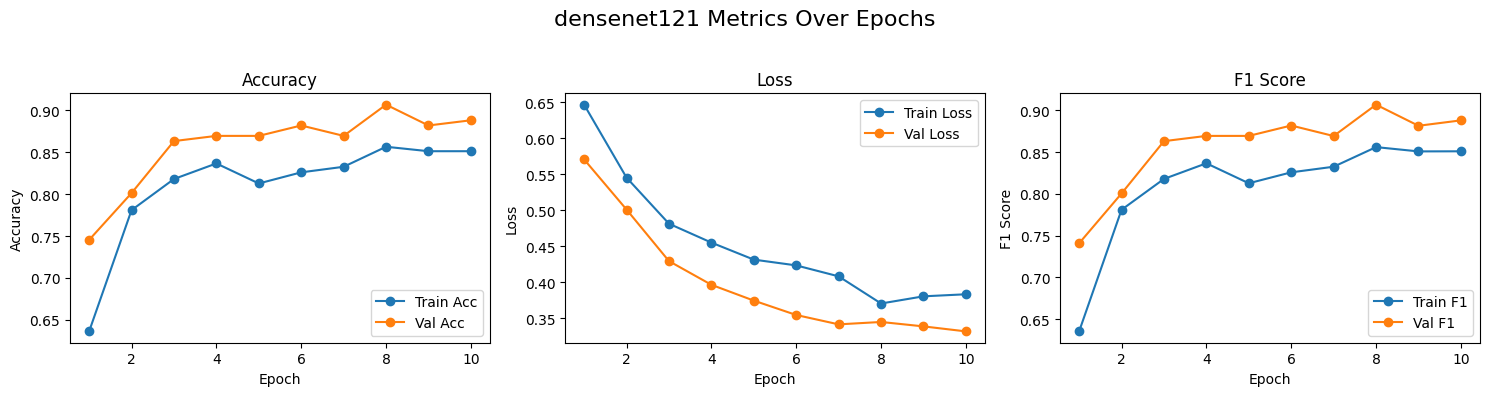

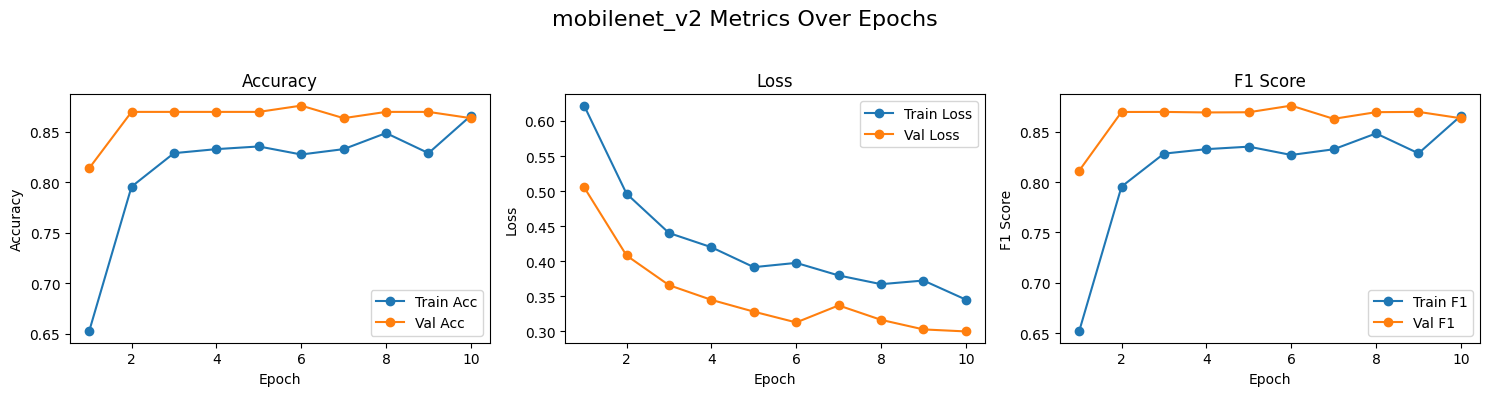

In [8]:
# chart metrics
with open(metrics_file, 'r') as f:
    metrics = json.load(f)
for name, h in metrics.items():
    epochs = list(range(1, NUM_EPOCHS+1))
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle(f"{name} Metrics Over Epochs", fontsize=16)

    axes[0].plot(epochs, h['train_acc'], marker='o', label='Train Acc')
    axes[0].plot(epochs, h['val_acc'],   marker='o', label='Val Acc')
    axes[0].set_title("Accuracy")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Accuracy")
    axes[0].legend()

    axes[1].plot(epochs, h['train_loss'], marker='o', label='Train Loss')
    axes[1].plot(epochs, h['val_loss'],   marker='o', label='Val Loss')
    axes[1].set_title("Loss")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Loss")
    axes[1].legend()

    axes[2].plot(epochs, h['train_f1'], marker='o', label='Train F1')
    axes[2].plot(epochs, h['val_f1'],   marker='o', label='Val F1')
    axes[2].set_title("F1 Score")
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("F1 Score")
    axes[2].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

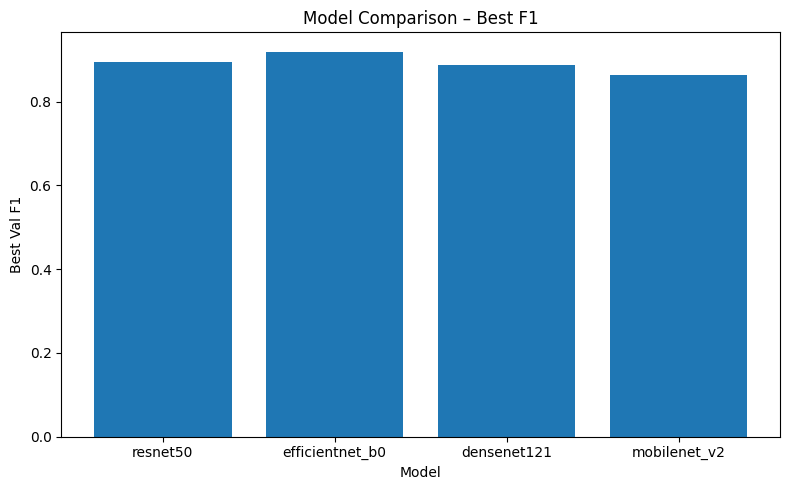

In [9]:
# so sánh best F1 
plt.figure(figsize=(8,5))
plt.bar(results.keys(), results.values())
plt.xlabel("Model")
plt.ylabel("Best Val F1")
plt.title("Model Comparison – Best F1")
plt.tight_layout()
plt.show()

In [10]:
test_indices = test_ds.indices
all_samples = full_ds.samples
test_paths  = [all_samples[i][0] for i in test_indices]
test_labels = [all_samples[i][1] for i in test_indices]

In [11]:
def show_test_samples(model_name: str, n: int = 4):
    """
    Hiển thị n ảnh random từ tập test với:
     - Tên file
     - Nhãn thực (True)
     - Dự đoán (Pred)
    """
    # Load model & checkpoint
    model = get_model(model_name)
    ckpt  = os.path.join(models_dir, f"{model_name}_best.pth")
    model.load_state_dict(torch.load(ckpt))
    model.eval()

    # Sample ngẫu nhiên
    samples = random.sample(list(zip(test_paths, test_labels)), n)

    plt.figure(figsize=(4*n, 4))
    for i, (path, true_lbl) in enumerate(samples, 1):
        img = Image.open(path).convert('RGB')
        inp = transforms_dict['val'](img).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            pred = model(inp).argmax(1).item()

        ax = plt.subplot(1, n, i)
        ax.imshow(img)
        ax.axis('off')
        # Tiêu đề: tên file, True label, Pred label
        ax.set_title(
            f"{os.path.basename(path)}\n"
            f"True: {full_ds.classes[true_lbl]} | Pred: {full_ds.classes[pred]}",
            fontsize=8
        )
    plt.suptitle(f"{model_name} Test Samples", fontsize=12)
    plt.tight_layout()
    plt.show()

c:\Users\MANH TUAN\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\MANH TUAN\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\MANH TUAN\AppData\Local\Temp\ipykernel_14280\2772824250.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary 

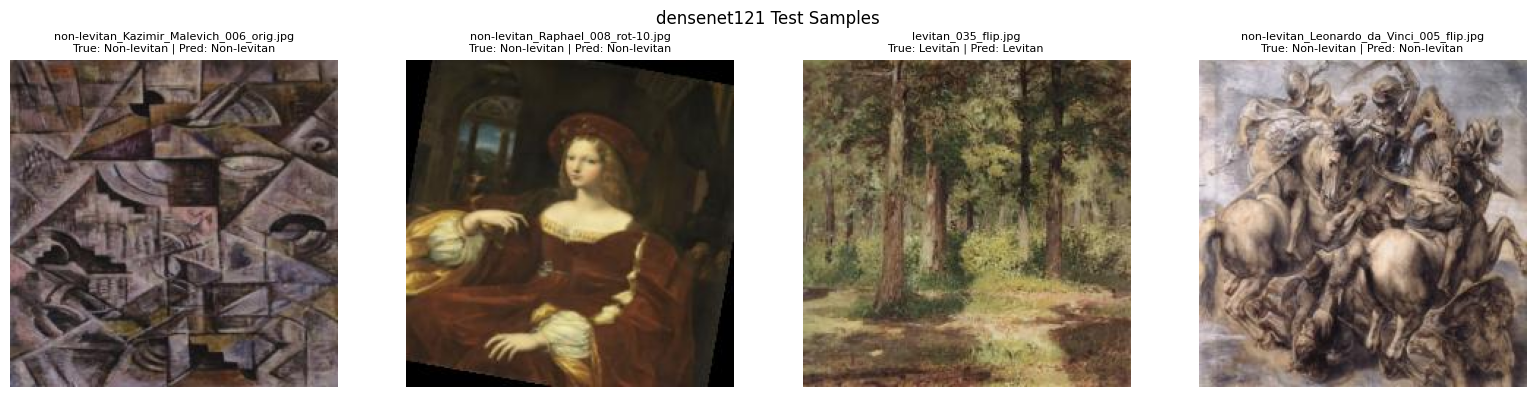

c:\Users\MANH TUAN\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


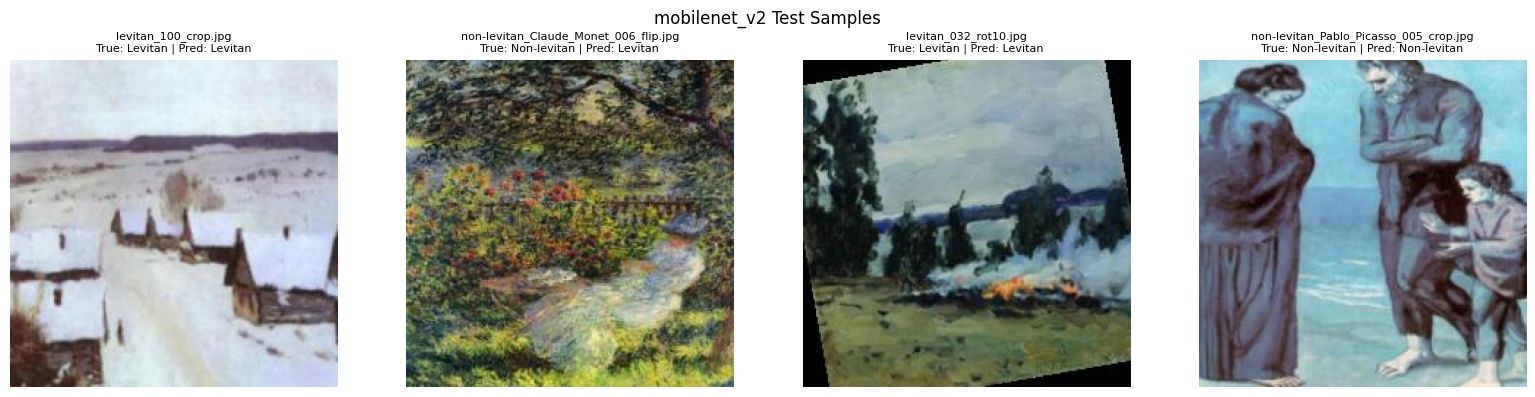

c:\Users\MANH TUAN\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


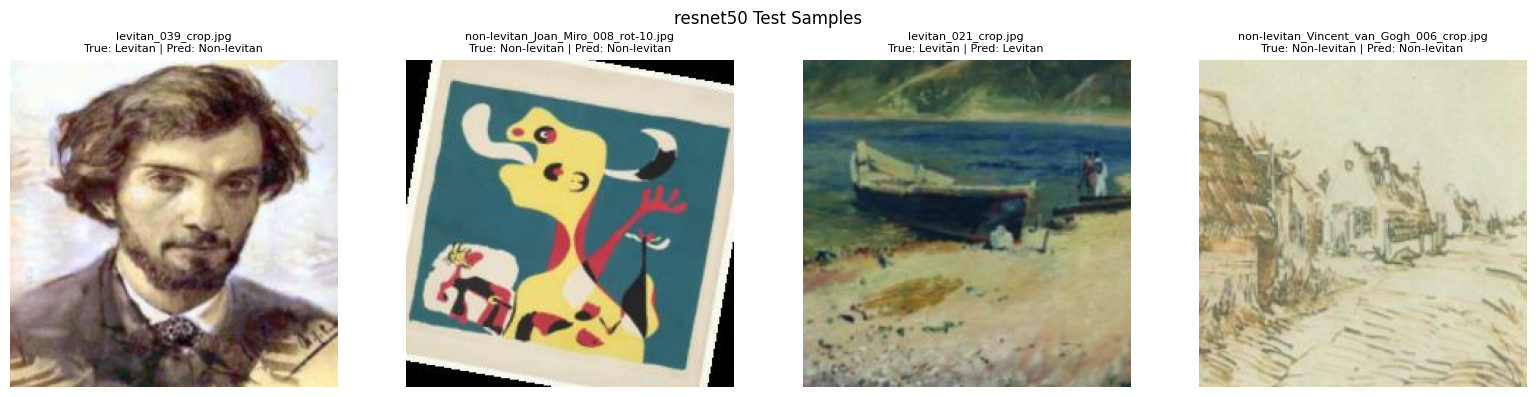

c:\Users\MANH TUAN\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


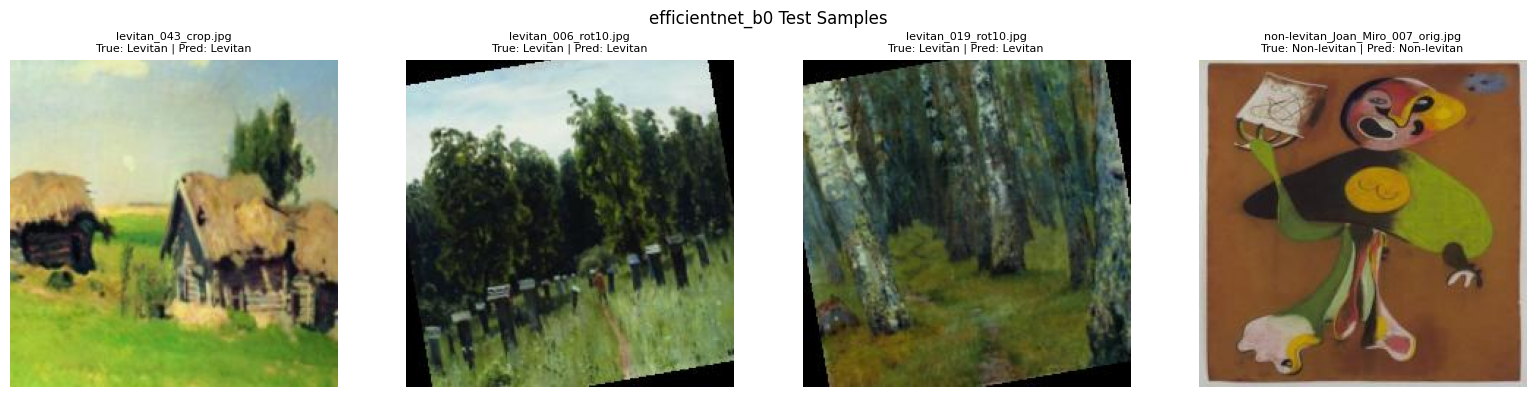

In [12]:
# test models qua tệp test
show_test_samples('densenet121', n=4)
show_test_samples('mobilenet_v2', n=4)
show_test_samples('resnet50', n=4)
show_test_samples('efficientnet_b0', n=4)

In [13]:
precisions = {}
recalls    = {}
f1s        = {}

for name in model_names:
    model = get_model(name)
    ckpt  = os.path.join(models_dir, f"{name}_best.pth")
    state = torch.load(ckpt, map_location=DEVICE)
    model.load_state_dict(state)
    model.to(DEVICE).eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in dataloaders['test']:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            out = model(imgs)
            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    precisions[name] = precision_score(all_labels, all_preds, average='weighted')
    recalls[name]    = recall_score(all_labels, all_preds, average='weighted')
    f1s[name]        = f1_score(all_labels, all_preds, average='weighted')

C:\Users\MANH TUAN\AppData\Local\Temp\ipykernel_14280\4099285880.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt, map_location=DEVICE)
c:\Users\M

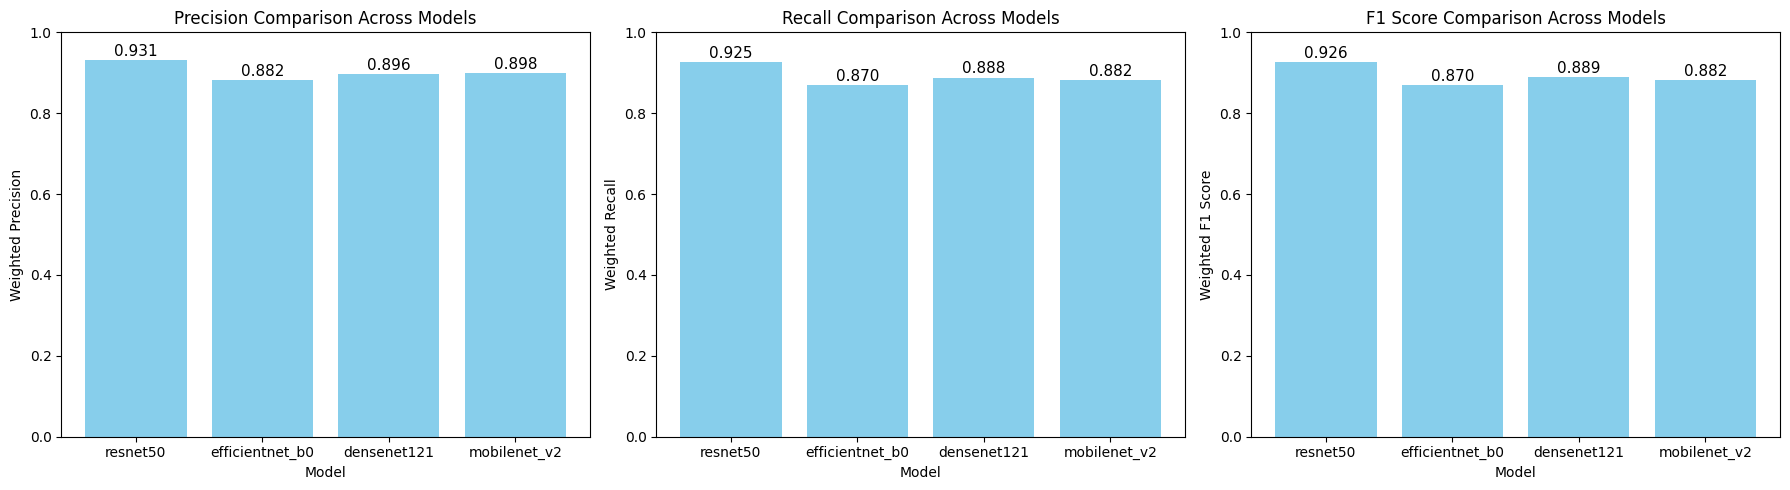

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))
metrics_dicts = [
    ('Precision', precisions, 'Weighted Precision'),
    ('Recall', recalls, 'Weighted Recall'),
    ('F1 Score', f1s, 'Weighted F1 Score'),
]
for ax, (title, values, ylabel) in zip(axes, metrics_dicts):
    vals = [values[name] for name in model_names]
    bars = ax.bar(model_names, vals, color='skyblue')
    ax.set_title(f'{title} Comparison Across Models')
    ax.set_xlabel("Model")
    ax.set_ylabel(ylabel)
    for bar, v in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width()/2, v + 0.01, f"{v:.3f}", ha='center', fontsize=11)
    ax.set_ylim([0,1])
plt.tight_layout()
plt.show()

C:\Users\MANH TUAN\AppData\Local\Temp\ipykernel_14280\3406049978.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(models_di

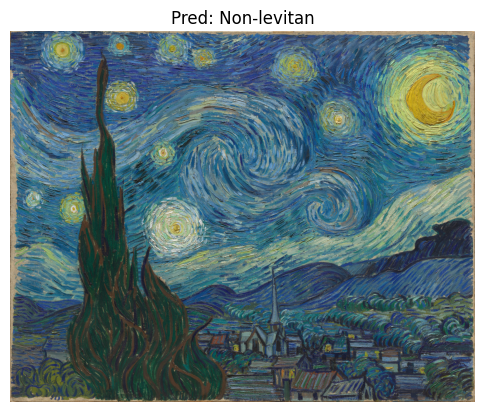

In [17]:
# thực hiện trên ảnh bất kỳ 
def show_prediction(img_path: str, model, transform, class_names):
    img = Image.open(img_path).convert("RGB")
    inp = transform(img).unsqueeze(0).to(DEVICE)

    model.eval()
    with torch.no_grad():
        pred = model(inp).argmax(1).item()

    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Pred: {class_names[pred]}", fontsize=12)
    plt.show()

model = get_model('resnet50')
model.load_state_dict(torch.load(os.path.join(models_dir, "resnet50_best.pth")))

img_path = r"Test set\the-starry-night-1889.jpg"
show_prediction(img_path, model, transforms_dict['val'], full_ds.classes)